# Exponential Smoothing Model in Python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from scipy.optimize import minimize

In [2]:
# parser for dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

In [3]:
data = pd.read_csv("shampoo.csv", header=0, index_col=0, parse_dates=True, date_parser=parser)
data = data.asfreq('MS')

<AxesSubplot:xlabel='Month'>

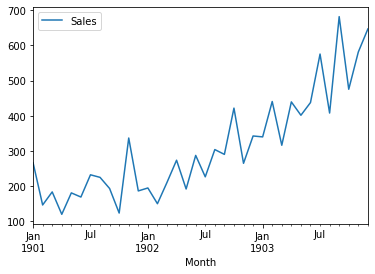

In [4]:
data.plot()

In [5]:
def generate_SES(params, y):
    alpha, l_0 = params
    levels = [l_0]
    preds = [l_0]
    for t in range(1,len(data)):
        level = alpha * y[t-1] + (1 - alpha) * levels[t-1]
        levels.append(level)
        preds.append(level)
    errors = pd.Series(y - preds, index=y.index)
    preds = pd.Series(preds, index=y.index)
    return errors, preds

In [6]:
def SES_param_estimate(params, y):
    # return sum of squared errors for optimiser
    errors, preds = generate_SES(params, y)
    return np.sum(errors**2)

In [7]:
def SES(data_series, h=15):
    data_series = data_series.asfreq('MS')
    
    data = pd.DataFrame(data_series.values, index=data_series.index, columns=["original"])

    y = data["original"]

    # optimise the paramters
    params = minimize(SES_param_estimate, [0.5, y[0]], bounds=[(0,1), (None,None)], args=(y,)).x
    
    errors, preds = generate_SES(params, y)
    data["preds"] = preds

    forecasts = pd.DataFrame()
    forecasts["original"] = data["original"]
    forecasts["predicted"] = data["preds"]
    forecasts["forecast"] = None

    forecast = params[0] * y[-1] + (1-params[0]) * preds[-1]
    for _ in range(h):
        next_time = forecasts.index[-1] + forecasts.index.freq
        forecasts.loc[next_time] = [np.NaN, np.NaN, forecast]
        forecasts = forecasts.asfreq('MS')
        
    forecasts[["original", "forecast"]].plot(color=["C0", "green"])
    # plt.savefig(f"simple_exp_forecast", bbox_inches="tight")
    plt.show()
    data.plot()
    # plt.savefig(f"simple_exp_fit", bbox_inches="tight")
    plt.show()
    print(f"{params = }")
    return data

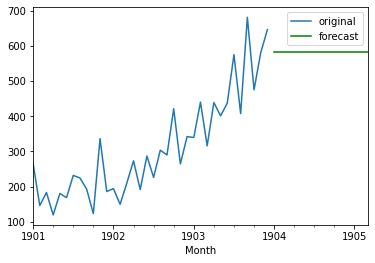

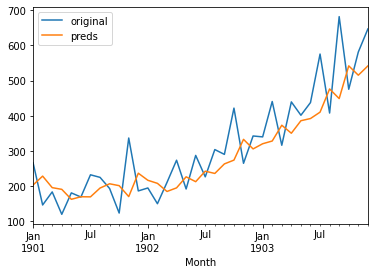

params = array([  0.39938453, 202.77778347])


In [8]:
res = SES(data, h=15)

In [9]:
def generate_holt_linear(params, y, phi):
    alpha, beta, l_0, b_0 = params
    levels = [l_0]
    slopes = [b_0]
    preds = [l_0 + b_0]

    for t in range(1, len(y)+1):
        level = alpha*y[t-1] + (1-alpha)*(levels[t-1] + phi*slopes[t-1])
        levels.append(level)
        slope = beta*(levels[t] - levels[t-1]) + (1-beta)*phi*slopes[t-1]
        slopes.append(slope)
        if t != len(y):
            preds.append(levels[t-1] + slopes[t-1])
        
    errors = pd.Series(y - preds, index=y.index)
    preds = pd.Series(preds, index=y.index)
    return errors, preds, levels[-1], slopes[-1]

In [10]:
def holt_linear_param_estimate(params, y, phi):
    # return sum of squared errors for optimiser
    errors, preds, last_level, last_slope = generate_holt_linear(params, y, phi)
    return np.sum(errors**2)

In [11]:
def holt_linear(data_series, phi=1, h=1):
    data_series = data_series.asfreq('MS')
    
    data = pd.DataFrame(data_series.values, index=data_series.index, columns=["original"])

    y = data["original"]

    # optimise the paramters
    params = minimize(holt_linear_param_estimate, [0.4, 0.4, y[0], y[1]-y[0]], tol=0.001, bounds=[(0,1), (0,1), (None,None), (None,None)], args=(y,phi)).x
    
    errors, preds, last_level, last_slope = generate_holt_linear(params, y, phi)
    data["preds"] = preds

    forecasts = pd.DataFrame()
    forecasts["original"] = data["original"]
    forecasts["predicted"] = data["preds"]
    forecasts["forecast"] = None

    for i in range(h):
        if phi == 1:
            forecast = last_level + (i+1) * last_slope
        else:
            phis = 0
            for j in range(1,i+1):
                phis += phi ** j
            forecast = last_level + phis * last_slope
        next_time = forecasts.index[-1] + forecasts.index.freq
        forecasts.loc[next_time] = [np.NaN, np.NaN, forecast]
        forecasts = forecasts.asfreq('MS')

    forecasts[["original", "forecast"]].plot(color=["C0", "green"])
    # plt.savefig(f"holt_linear_forecast", bbox_inches="tight")
    plt.show()
    data.plot()
    # plt.savefig(f"holt_linear_fit", bbox_inches="tight")
    plt.show()
    print(f"{params = }")
    return data

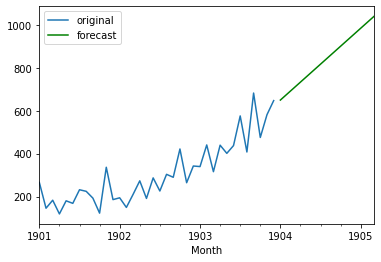

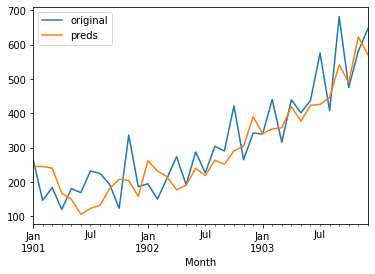

params = array([  0.48709065,   0.27116407, 262.93253147, -18.01424375])


In [12]:
res = holt_linear(data, h=15)

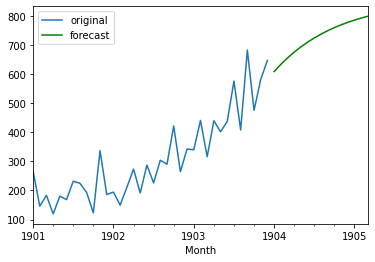

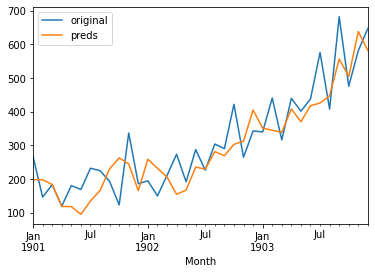

params = array([  0.36083329,   1.        , 270.52411188, -72.86372734])


In [13]:
res, params = holt_linear(data, phi=0.9, h=15) # cahnge phi to see different plots

In [14]:
# load dataset
def milk_parser(x):
	return datetime.strptime(x, '%Y-%m')

In [15]:
milk = pd.read_csv("milk.csv", header=0, index_col=0, parse_dates=True, date_parser=milk_parser)
milk = milk.asfreq('MS')
milk

,Milk
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


In [16]:
def generate_holt_winters_add(params, y, m):
    alpha, beta, gamma, l_0, b_0, *s = params
    levels = [l_0]
    slopes = [b_0]
    seasons = s
    preds = [l_0 + b_0 + s[0]]

    for t in range(1, len(y)+1):
        # y_t in equation corresponds to y[t-1] in code since t starts at index 1
        level = alpha * (y[t-1] - seasons[t-m]) + (1-alpha) * (levels[t-1] + slopes[t-1])
        levels.append(level)
        slope = beta * (levels[t] - levels[t-1]) + (1-beta) * slopes[t-1]
        slopes.append(slope)
        season = gamma * (y[t-1] - levels[t-1] - slopes[t-1]) + (1-gamma) * seasons[t-m]
        seasons.append(season)
        if t != len(y):
            # don't add last prediction (first forecast)
            preds.append(levels[t-1] + slopes[t-1] + seasons[t-m])
        
    errors = pd.Series(y - preds, index=y.index)
    preds = pd.Series(preds, index=y.index)

    return errors, preds, levels[-1], slopes[-1], seasons[-m:]

In [17]:
def generate_holt_winters_mult(params, y, m):
    alpha, beta, gamma, l_0, b_0, *s = params
    levels = [l_0]
    slopes = [b_0]
    seasons = s
    preds = [l_0 + b_0 + s[0]]

    for t in range(1, len(y)+1):
        # y_t in equation corresponds to y[t-1] in code since t starts at index 1
        level = alpha * (y[t-1]/seasons[t-m]) + (1-alpha) * (levels[t-1] + slopes[t-1])
        levels.append(level)
        slope = beta * (levels[t] - levels[t-1]) + (1-beta) * slopes[t-1]
        slopes.append(slope)
        season = gamma * (y[t-1]/(levels[t-1] + slopes[t-1])) + (1-gamma) * seasons[t-m]
        seasons.append(season)
        if t != len(y):
            # don't add last prediction (first forecast)
            preds.append((levels[t-1] + slopes[t-1]) * seasons[t-m])
        
    errors = pd.Series(y - preds, index=y.index)
    preds = pd.Series(preds, index=y.index)
    
    return errors, preds, levels[-1], slopes[-1], seasons[-m:]

In [18]:
def holt_winters_param_estimate(params, y, m, mode):
    if mode == "add":
        errors, preds, last_level, last_slope, last_season = generate_holt_winters_add(params, y, m)
    else:
        errors, preds, last_level, last_slope, last_season = generate_holt_winters_mult(params, y, m)
    return np.sum(errors**2)

In [19]:
def initial_trend_component(data, m):
    total = 0
    for i in range(m):
        total += (data[i+m] - data[i]) / m
    return total / m

In [20]:
def initial_seasonal_components(data, m, mode):
    seasonals = []
    seasonal_averages = []
    n_seasons = len(data) // m
    # seasonal averages
    for i in range(n_seasons):
        seasonal_averages.append(sum(data[m*i:m*i+m])/m)
        
    # initial seasonal components
    for i in range(m):
        sum_yearly_averages = 0
        for j in range(n_seasons):
            # subtract for "add" and divide for "mult"
            if mode == "add":
                sum_yearly_averages += data[i+j*m]-seasonal_averages[j]
            else:
                sum_yearly_averages += data[i+j*m]/seasonal_averages[j]
        seasonals.append(sum_yearly_averages/m)

    return seasonals

In [21]:
def holt_winters(data_series, mode, m=1, h=1):
    data_series = data_series.asfreq('MS')
    
    data = pd.DataFrame(data_series.values, index=data_series.index, columns=["original"])
    y = data["original"]
    initial_trend = initial_trend_component(y, m)
    initial_seasonal = initial_seasonal_components(y, m, mode)
    
    # optimise the paramters
    params = minimize(holt_winters_param_estimate, [0.2, 0.2, 0.2, y[0], initial_trend] + initial_seasonal, bounds=[(0,1), (0,1), (0,1), (None,None), (None,None)] + [(None,None)]*m, args=(y,m,mode)).x
    
    if mode == "add":
        errors, preds, last_level, last_slope, last_season = generate_holt_winters_add(params, y, m)
    else:
        errors, preds, last_level, last_slope, last_season = generate_holt_winters_mult(params, y, m)
    data["preds"] = preds

    forecasts = pd.DataFrame()
    forecasts["original"] = data["original"]
    forecasts["predicted"] = data["preds"]
    forecasts["forecast"] = None

    for i in range(h):
        k = (i-1)//m
        if mode == "add":
            forecast = last_level + i * last_slope + last_season[i-m*(k+1)]
        else:
            forecast = (last_level + i * last_slope) * last_season[i-m*(k+1)]

        next_time = forecasts.index[-1] + forecasts.index.freq
        forecasts.loc[next_time] = [np.NaN, np.NaN, forecast]
        forecasts = forecasts.asfreq('MS')

    forecasts[["original", "forecast"]].plot(color=["C0", "green"])
    # plt.savefig(f"holt_winters_{mode}_forecast", bbox_inches="tight")
    plt.show()
    data.plot()
    # plt.savefig(f"holt_winters_{mode}_fit", bbox_inches="tight")
    plt.show()

    print(f"{params = }")
    return data, forecasts

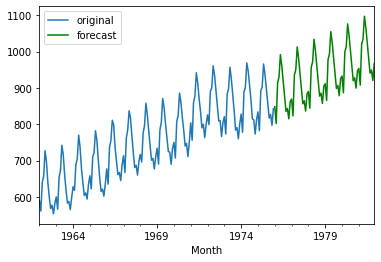

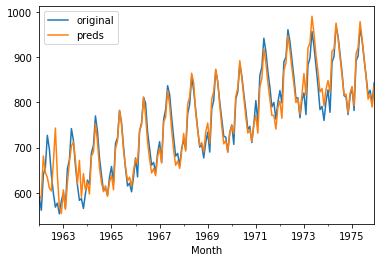

params = array([ 5.71588669e-02,  0.00000000e+00,  9.51094364e-01,  6.06072460e+02,
        1.76058052e+00, -2.41310321e+01, -6.78732275e+01, -1.35853292e+01,
        3.47296876e+01,  6.87881557e+01,  7.79008558e+01,  3.54479508e+01,
       -2.23703847e+01,  2.54796984e+01, -5.47594493e+01, -3.88313257e+00,
       -3.86871862e+01])


In [22]:
res_add, forecasts_add = holt_winters(milk, "add", m=12, h=12*6)

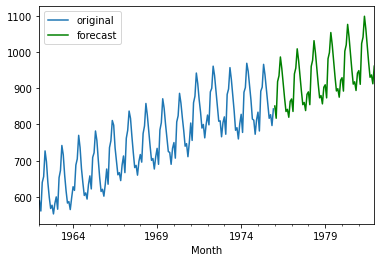

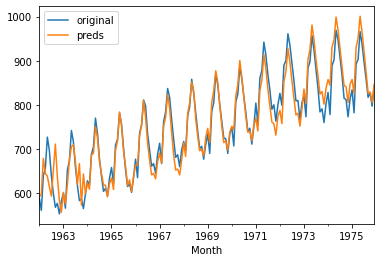

params = array([0.00000000e+00, 9.71339629e-02, 8.78157076e-01, 5.88995536e+02,
       1.66195529e+00, 9.88422636e-01, 9.42576283e-01, 1.01205268e+00,
       1.09986290e+00, 1.14576890e+00, 1.14913652e+00, 1.08492652e+00,
       9.99354913e-01, 1.07204734e+00, 9.18277030e-01, 1.02839753e+00,
       9.55041548e-01])


In [23]:
res_mult, forecasts_mult = holt_winters(milk, "mult", m=12, h=12*6)

<AxesSubplot:xlabel='Month'>

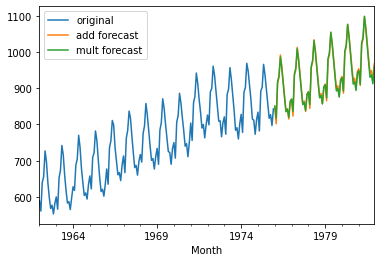

In [24]:
combined = pd.concat([res_add["original"], forecasts_add["forecast"], forecasts_mult["forecast"]], axis=1)
combined.columns = ["original", "add forecast", "mult forecast"]
combined.plot()
# plt.savefig(f"holt_winters_combined_forecast", bbox_inches="tight")